## Pipeline Architecture

Pipeline requirements:
1. Data Ingestion- Refresh frequency -daily
2. Forecasting frequency - daily
3. Forecast horizon - 72 hours
4. Robustness - unit tests, validation checks, logs, monitoring


Model registry
1. register best model from experimentation phase using mlfow flavour

In [ ]:
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
import mlflow
import mlforecast.flavor
from tomlkit import datetime

experiment_name = "forecasting_experiment"
mlflow_path = "./mlruns"
meta = mlflow.get_experiment_by_name(experiment_name)

model = LGBMRegressor(n_estimators=500, learning_rate=0.05)
params ={
    'freq': 'h',
    'lags': list(range(1, 24)),
    'date_features': ['hour', 'dayofweek', 'month']
}

mlf = MLForecast(
    models = [model],
    freq = params['freq'],
    lags = params['lags'],
    date_features = params['date_features']
)

mlf.fit(ts)

run_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f'lightgbm6_{run_time}'

with mlflow.start_run(experiment_id=meta.experiment_id, run_name=run_name) as run:
    mlforecast.flavor.log_model(model=mlf, artifact_path="prod_model")

In [ ]:
## Data ingestion and processing
## Data validation checks
from curses import raw
import pointblank as pb
table_schema = pb.Schema(
    columns=[
        ("index", 'datetotime64[ns]'),
        ("respondent", 'object'),
        ('respondent_name', 'object'),
        ('type', 'object'),
        ('type-name', 'object'),
        ('value', 'int64'),
        ('value-units', 'object'),
    ]
)

validation = (pb.Validate(data=ts,
                tbl_name='US48 Data Validation',
                label='Data Refresh',
                thresholds=pb.Thresholds(warning=0.2, error =0, critical=0.1))
                .col_schema_match(schema=table_schema)
                .col_vals_gt(columns='value', value=0)
                .col_vals_in_set(columns='respondent', set=['US48'])
                .col_vals_in_set(columns='type', set=['D'])
                .col_vals_not_null(columns=['period', 'value'])
                .rows_distinct()
                .interrogate()
                )
print(validation.all_passed())




## Airflow pipeline
1. build a. supporting functions b. callable functions
2. set DAG structure
3. Test DAG locally


In [ ]:
import etl.eia_etl as ee
import etl.forecast_utls as fu
import etl.dags_functions as df

def check_updates_api(path, var):
    check = df.CheckUpdates()
    check.check_updates(path=path, var=var)
    return check.status


default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2025, 3, 15),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5)
}

with DAG(
    'data_pipeline',
    default_args=default_args,
    description='Data pipeline for ETL process',
    schedule='@daily',
    tags=['python', 'etl', 'forecasting'],
) as dag:

    check_api= PythonOperator(
        task_id='check_api',
        python_callable=cl.check_updates_api    ,
        op_kwargs={'path': './settings/settings.json', 'var': 'EPI_API_KEY'}
    )

    check_status = BranchPythonOperator(
        task_id='check_status',
        python_callable=cl.update_status,
        provide_context=True
    )

    data_refresh = BranchPythonOperator(
        task_id='data_refresh',
        python_callable=cl.data_refresh,
        provide_context=True, 
        op_kwargs={'var': api_key_var}
    )

    no_updates = PythonOperator(
        task_id='no_updates',
        python_callable=cl.no_updates,
        provide_context=True,
        op_kwargs={'save': save}
    )   

# Setting uo DAG structure
check_api >> check_status >> [data_refresh, no_updates]
data_refresh >> [data_validation, data_failure]
data_validation >> check_validation >> [data_valid, data_invalid]
data_valid >> forecast_refresh >> forecast_score


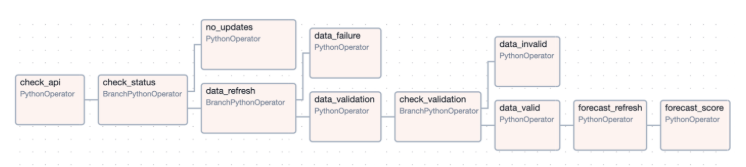

In [ ]:
# Import required classes
from airflow import DAG
from airflow.providers.standard.operators.python import PythonOperator
from datetime import datetime

default_args = {
  'owner': 'airflow',
  # Define the arguments
  'depends_on_past': False,
  'start_date': datetime(2025, 7, 7),
  'email_on_failure': False}

print(f"DAG configured to start on {default_args['start_date']}")


# Define the DAG
with DAG(
    'data_pipeline',
    default_args=default_args,
    description='Data pipeline for ETL process',
  	# Set the schedule to run daily
    schedule='@daily',
    tags = ["python", "etl", "forecast"]
) as dag:
  # Create check_api
  check_api = PythonOperator(
    task_id='check_api',
    # Use the check_updates_api function
    python_callable=check_updates_api)

print(f"DAG object created: {dag}")
print(f"PythonOperator for API check created: {check_api}") 


# Set the API check pipeline tasks
check_api >> check_status >> [data_refresh, no_updates]

data_refresh >> [data_validation, data_failure]

# Set the data validation pipeline tasks
data_validation >> check_validation >> [data_valid, data_invalid]

# Set the forecast pipeline tasks
data_valid >> forecast_refresh >> forecast_score

print(f"DAG '{dag.dag_id}' ready with {len(dag.tasks)} tasks")

## Logs
Logging- metadata, validations tests, status, performance metrics


In [ ]:
import etl.eia_etl as ee
log = ee.Log()
facet = {'respondent': 'US48',
         'type': 'D'}
log.create_log(facet=facets)

meta = ee.get_metadata(api_key=api_key,
                       api_path = api_meta_path,
                       meta_path=log_path,
                       facets=facets,
                       offset=22,
                       window=336)

if not meta.updates_available:
    log.no_updates()

get = ea.eia_get(api_key=api_key,
                 api_path=api_data_path,
                 data = 'value',
                 facets=facets,
                 start=meta.start,
                 end_date=meta.api_end_offset)

# in case fail
log.failure()

# otherwise validation process
test = ee.Validation(data=get.data,
                     tbl_name='get request',
                     label = 'validation',
                     parameters= get.parameters,
                     initial=False,
                     warning = 0.1,
                     error = 0,
                     critical = 0)

# validation object
schema_refresh = pb.Schema(
    columns=[
        ("index", 'datetotime64[ns]'),
        ("respondent", 'object'),
        ('respondent_name', 'object'),
        ('type', 'object'),
        ('type-name', 'object'),
        ('value', 'int64'),
        ('value-units', 'object'),
    ]
)

test.add_schema(schema=schema_refresh)

# if success
if log.log['status']:
    print('Appending the data')
    df = ee.AppendData()
    df.append_data(data_path=data_path,
                   new_data=get.data,
                   save=True,
                   schema=schema_append,
                   parameters=get.parameters)
    
print(df.validation)
if df.status and df.save:
    log.log['update'] = True
else:
    log.log['update'] = False

